In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
########## Balance mix strategy

In [3]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [4]:
busiest_day['Route'] = busiest_day['Route'].str.replace(r'\(X\)', '', regex=True) # replace (X)
busiest_day['Route'] = busiest_day['Route'].str.replace('X', '', regex=False) # replace X

In [5]:
### BM High-cap Scenario

In [6]:
h_BM_variables = pd.read_csv(r'../../results/highcap-BM-optimized-variables.csv', low_memory=False)

In [7]:
h_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [8]:
# Extract attributes from h_BM_variables
h_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
h_BM_variables = h_BM_variables.dropna()
h_BM_variables['Year'] = h_BM_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from h_BM_coefficients
h_BM_coefficients[['Scenario', 'Year', 'Trip']] = h_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
h_BM_coefficients = h_BM_coefficients.dropna()
h_BM_coefficients['Year'] = h_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
h_BM_coefficients['Trip'] = h_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(h_BM_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update h_BM_variables
h_BM_variables = merged_df

In [9]:
# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_BM_variables
h_BM_variables = merged_df

h_BM_variables['ServiceDateTime_min'] = pd.to_datetime(h_BM_variables['ServiceDateTime_min'])
h_BM_variables['ServiceDateTime_max'] = pd.to_datetime(h_BM_variables['ServiceDateTime_max'])
#h_BM_variables['Value'] = pd.to_numeric(h_BM_variables['Value'])

In [10]:
h_BM_variables.to_csv(r'../../results/highcap-BM-optimized-variables-aggregated.csv', index=False)

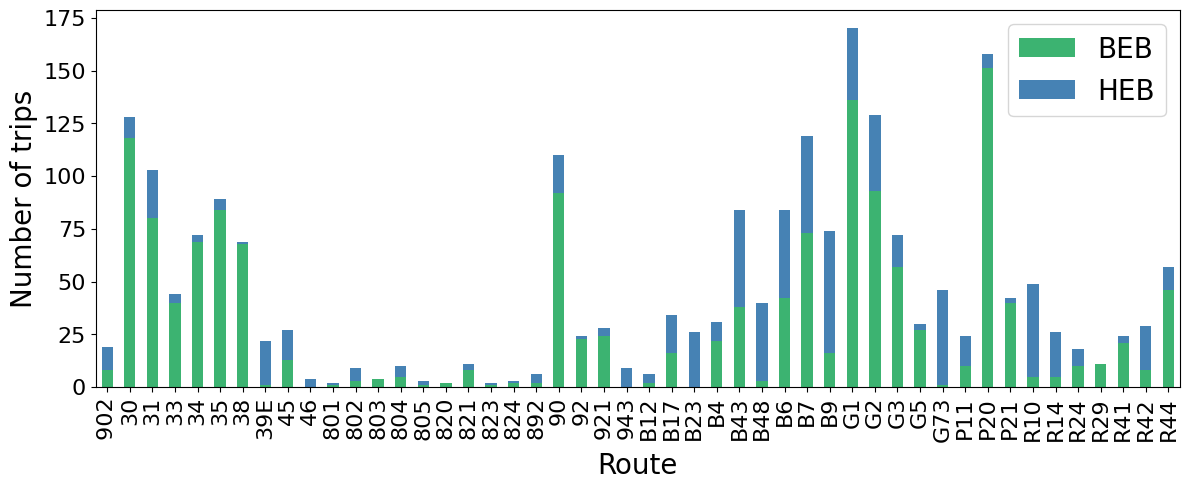

In [10]:
# Filter the dataframe for Year=13 and Value=1
h_BM_variables_filtered = h_BM_variables[(h_BM_variables['Year'] == 12) & (h_BM_variables['Value'] == 1)]
h_BM_variables_filtered = h_BM_variables_filtered[h_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)
#ax.set_xlabel('')
#ax.set_xticks([])
# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()

fig.savefig(r'../../figures/h_BM_route_electrification.png', dpi=400)  

plt.show()


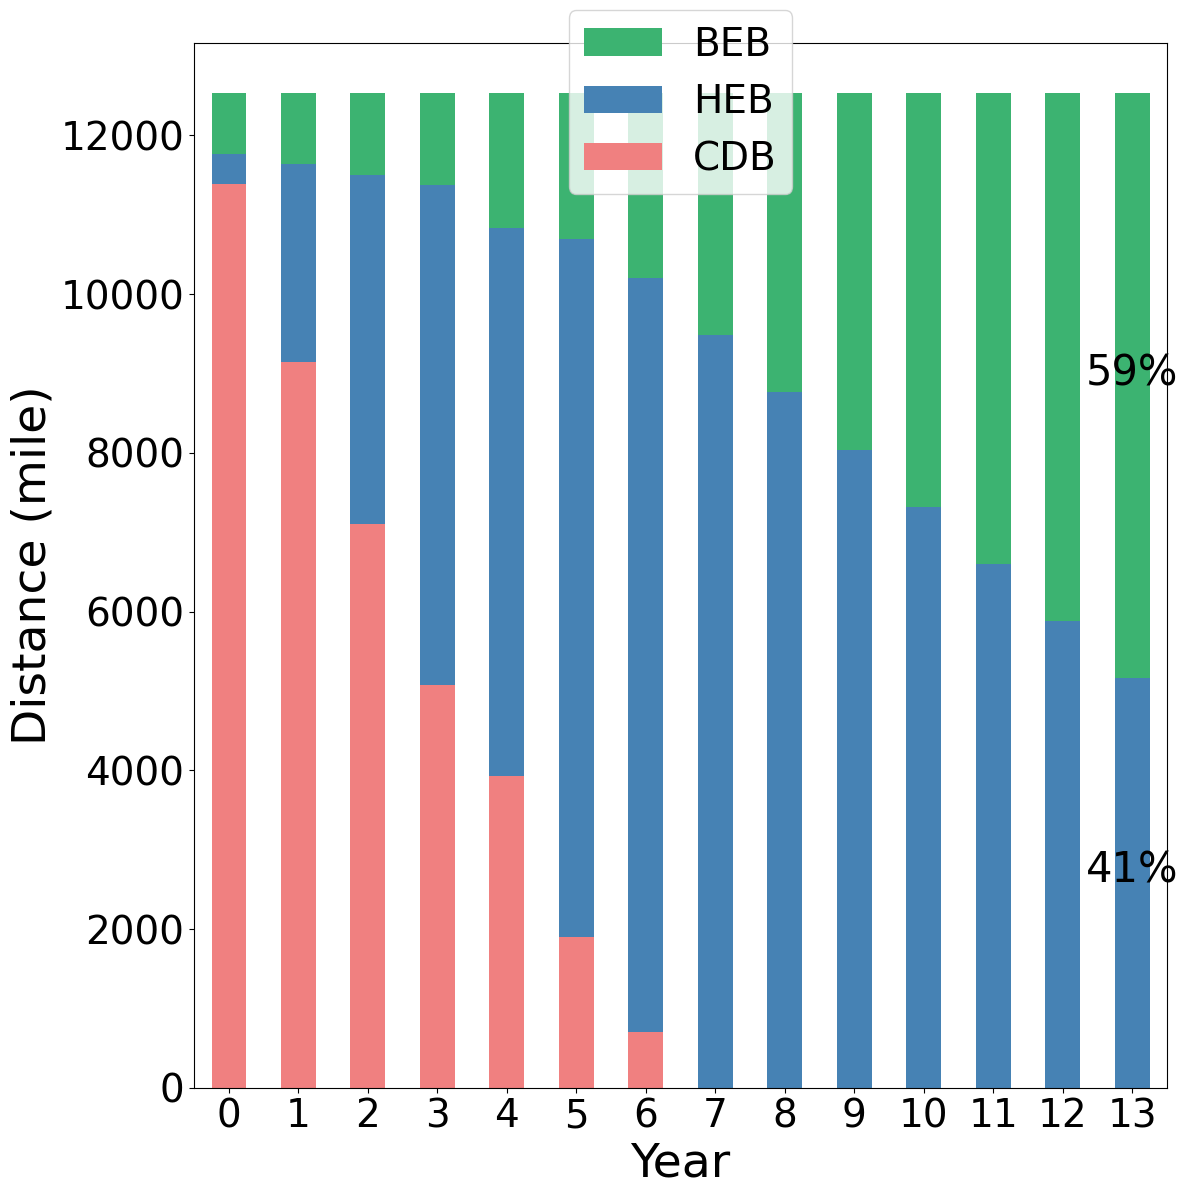

In [13]:
# Sum the 'dist' for each 'Powertrain' and 'Year'
h_BM_variables_values = h_BM_variables[h_BM_variables['Value'] == 1]
sum_dist = h_BM_variables_values.groupby(['Year', 'Powertrain'])['dist'].sum().reset_index()

# Pivot the DataFrame for easier plotting
pivot_dist = sum_dist.pivot(index='Year', columns='Powertrain', values='dist').fillna(0)

# Shift years by one
pivot_dist.reset_index(inplace=True)
pivot_dist['Year'] = pivot_dist['Year'] + 1

# Adding the new row for Year 0 (2022)
new_row = pd.DataFrame({'Year': [0], 'CDB': [11386], 'HEB': [382], 'BEB': [772]})
pivot_dist = pd.concat([pivot_dist, new_row], ignore_index=True)

# Sorting the DataFrame by Year
pivot_dist = pivot_dist.sort_values(by='Year').reset_index(drop=True)

# Setting the 'Year' as the index again if you want
pivot_dist.set_index('Year', inplace=True)

# Reorder the columns
pivot_dist = pivot_dist[['CDB', 'HEB', 'BEB']]

# Compute the percentage for annotation
pivot_percentage = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Define the colors
colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
pivot_dist.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_dist.columns], ax=ax)

# Annotate each bar with the corresponding percentage for the last year only
last_year_idx = len(pivot_dist.index) - 1
total_dist = 0
for j, powertrain in enumerate(pivot_dist.columns):
    percentage = pivot_percentage.loc[pivot_dist.index[last_year_idx], powertrain]
    dist = pivot_dist.loc[pivot_dist.index[last_year_idx], powertrain]
    if dist > 0:
        ax.text(last_year_idx, total_dist + dist / 2, f'{round(percentage)}%', ha='center', color='black', fontsize=30)
    total_dist += dist

# Setting labels, title, and making the fonts larger
plt.xlabel('Year', fontsize=34)
plt.ylabel('Distance (mile)', fontsize=34)
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=28, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(r'../../figures/h_BM_milage_electrification.png', dpi=400)

plt.show()


In [14]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 67.89%


In [15]:
h_BM_variables_y = pd.read_csv(r'../../results/highcap-BM-optimized-variables-y.csv', low_memory=False)

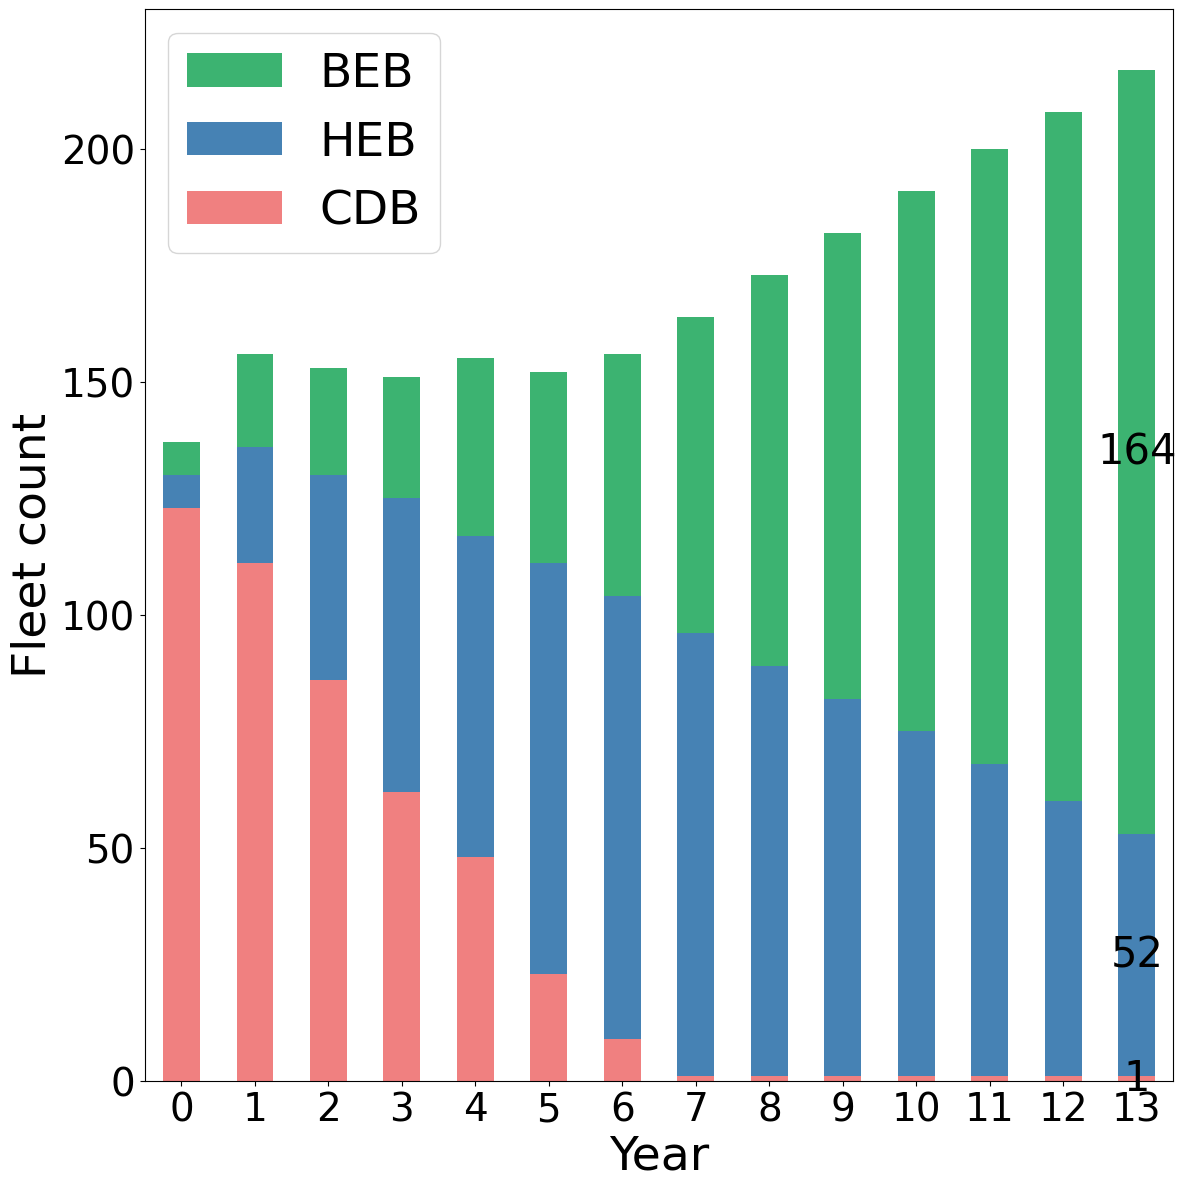

In [16]:
# Group by Year and Powertrain to sum up the Value
grouped_values = h_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Reorder the columns
grouped_values = grouped_values[['CDB', 'HEB', 'BEB']]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values for the last bar
for container_idx, container in enumerate(ax.containers):
    for rect_idx, rect in enumerate(container):
        if rect_idx == len(container) - 1:  # Annotate only the last bar
            height = rect.get_height()
            ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        ha='center', 
                        va='center',
                        color='black',  
                        fontsize=30)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=34)
ax.set_ylabel('Fleet count', fontsize=34)

# Reverse the order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34)

ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 230)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=28)

plt.tight_layout()

fig.savefig(r'../../figures/h_BM_fleet.png', dpi=400)  

plt.show()


In [17]:
total_sum = (h_BM_variables['Value'] * h_BM_variables['Coefficient']).sum()
print(total_sum)

20655.929239111


In [18]:
### BM Mid-cap Scenario

In [19]:
m_BM_variables = pd.read_csv(r'../../results/midcap-BM-optimized-variables.csv', low_memory=False)

In [20]:
m_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [21]:
# Extract attributes from m_BM_variables
m_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
m_BM_variables = m_BM_variables.dropna()
m_BM_variables['Year'] = m_BM_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from m_BM_coefficients
m_BM_coefficients[['Scenario', 'Year', 'Trip']] = m_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
m_BM_coefficients = m_BM_coefficients.dropna()
m_BM_coefficients['Year'] = m_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
m_BM_coefficients['Trip'] = m_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(m_BM_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update m_BM_variables
m_BM_variables = merged_df

In [22]:
# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update m_BM_variables
m_BM_variables = merged_df

m_BM_variables['ServiceDateTime_min'] = pd.to_datetime(m_BM_variables['ServiceDateTime_min'])
m_BM_variables['ServiceDateTime_max'] = pd.to_datetime(m_BM_variables['ServiceDateTime_max'])


In [23]:
m_BM_coefficients

,Powertrain,Variable,Coefficient,Scenario,Year,Trip
0,CDB,"('high-cap', 0, 504451)",0.247132,high-cap,0,504451
1,CDB,"('high-cap', 1, 504451)",0.247132,high-cap,1,504451
2,CDB,"('high-cap', 2, 504451)",0.247132,high-cap,2,504451
3,CDB,"('high-cap', 3, 504451)",0.247132,high-cap,3,504451
4,CDB,"('high-cap', 4, 504451)",0.247132,high-cap,4,504451
...,...,...,...,...,...,...
99367,BEB,"('high-cap', 9, 507069)",0.000000,high-cap,9,507069
99368,BEB,"('high-cap', 10, 507069)",0.000000,high-cap,10,507069
99369,BEB,"('high-cap', 11, 507069)",0.000000,high-cap,11,507069
99370,BEB,"('high-cap', 12, 507069)",0.000000,high-cap,12,507069


In [23]:
m_BM_variables.to_csv(r'../../results/midcap-BM-optimized-variables-aggregated.csv', index=False)

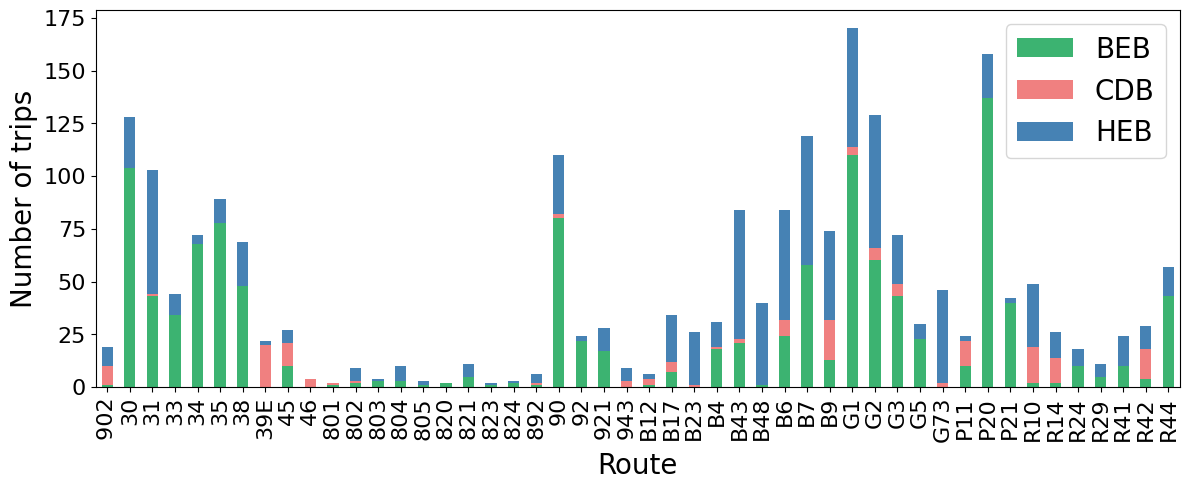

In [24]:
# Filter the dataframe for Year=13 and Value=1
m_BM_variables_filtered = m_BM_variables[(m_BM_variables['Year'] == 12) & (m_BM_variables['Value'] == 1)]
m_BM_variables_filtered = m_BM_variables_filtered[m_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/m_BM_route_electrification.png', dpi=400)  

plt.show()


In [25]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 53.50%


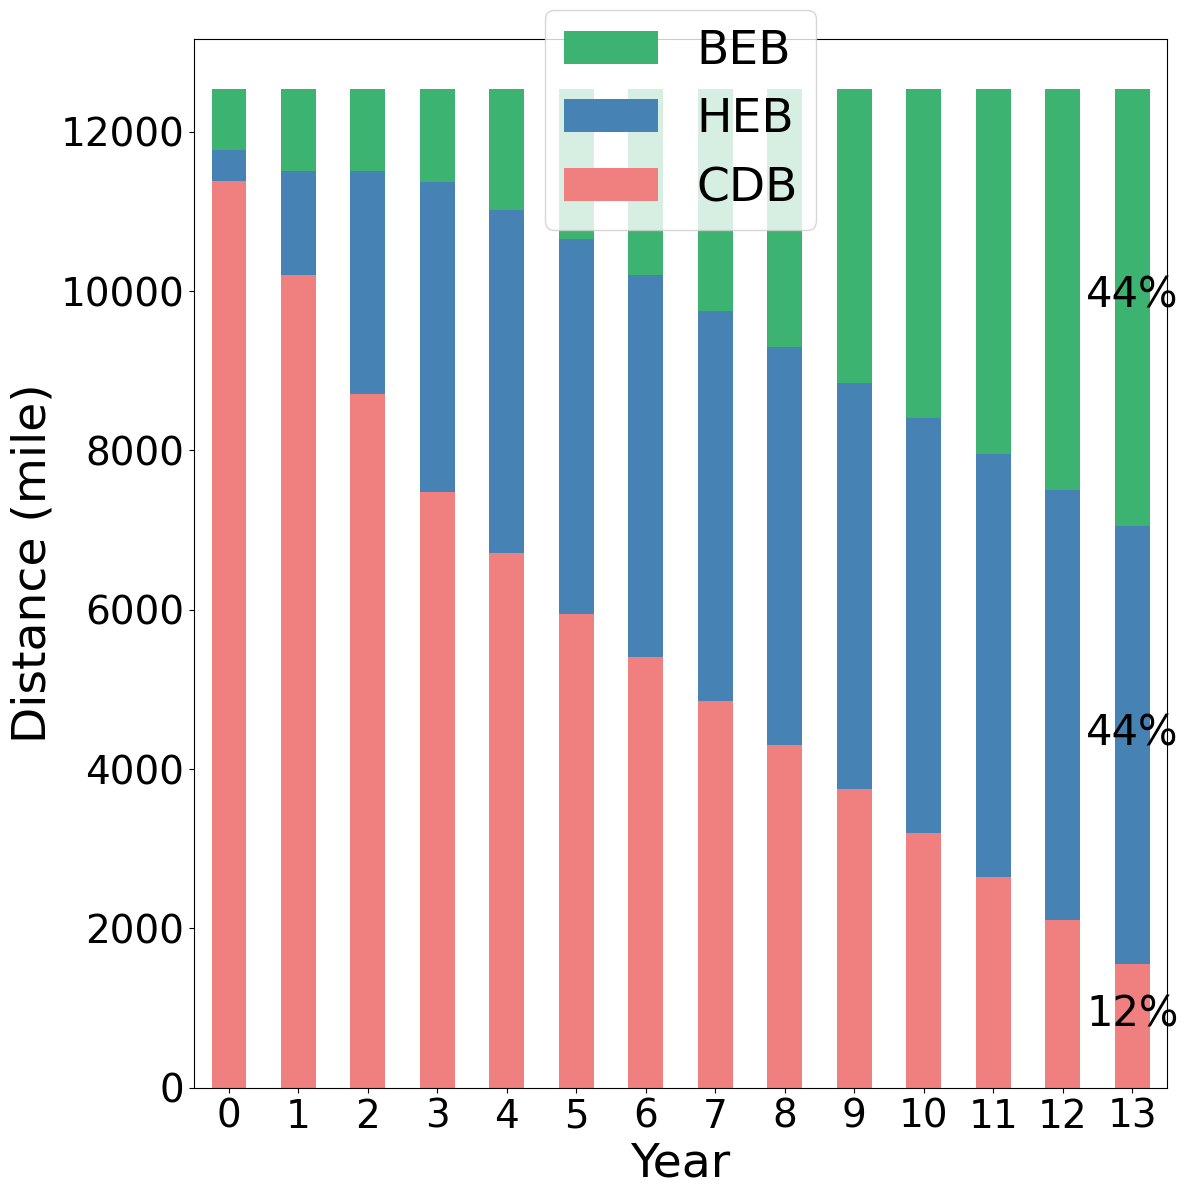

In [27]:
# Sum the 'dist' for each 'Powertrain' and 'Year'
m_BM_variables_values = m_BM_variables[m_BM_variables['Value'] == 1]
sum_dist = m_BM_variables_values.groupby(['Year', 'Powertrain'])['dist'].sum().reset_index()

# Pivot the DataFrame for easier plotting
pivot_dist = sum_dist.pivot(index='Year', columns='Powertrain', values='dist').fillna(0)

# Shift years by one
pivot_dist.reset_index(inplace=True)
pivot_dist['Year'] = pivot_dist['Year'] + 1

# Adding the new row for Year 0 (2022)
new_row = pd.DataFrame({'Year': [0], 'CDB': [11386], 'HEB': [382], 'BEB': [772]})
pivot_dist = pd.concat([pivot_dist, new_row], ignore_index=True)

# Sorting the DataFrame by Year
pivot_dist = pivot_dist.sort_values(by='Year').reset_index(drop=True)

# Setting the 'Year' as the index again if you want
pivot_dist.set_index('Year', inplace=True)

# Reorder the columns
pivot_dist = pivot_dist[['CDB', 'HEB', 'BEB']]

# Compute the percentage for annotation
pivot_percentage = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Define the colors
colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
pivot_dist.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_dist.columns], ax=ax)

# Annotate each bar with the corresponding percentage for the last year only
last_year_idx = len(pivot_dist.index) - 1
total_dist = 0
for j, powertrain in enumerate(pivot_dist.columns):
    percentage = pivot_percentage.loc[pivot_dist.index[last_year_idx], powertrain]
    dist = pivot_dist.loc[pivot_dist.index[last_year_idx], powertrain]
    if dist > 0:
        ax.text(last_year_idx, total_dist + dist / 2, f'{round(percentage)}%', ha='center', color='black', fontsize=30)
    total_dist += dist

# Setting labels, title, and making the fonts larger
plt.xlabel('Year', fontsize=34)
plt.ylabel('Distance (mile)', fontsize=34)
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(r'../../figures/m_BM_milage_electrification.png', dpi=400)

plt.show()


In [28]:
m_BM_variables_y = pd.read_csv(r'../../results/midcap-BM-optimized-variables-y.csv', low_memory=False)

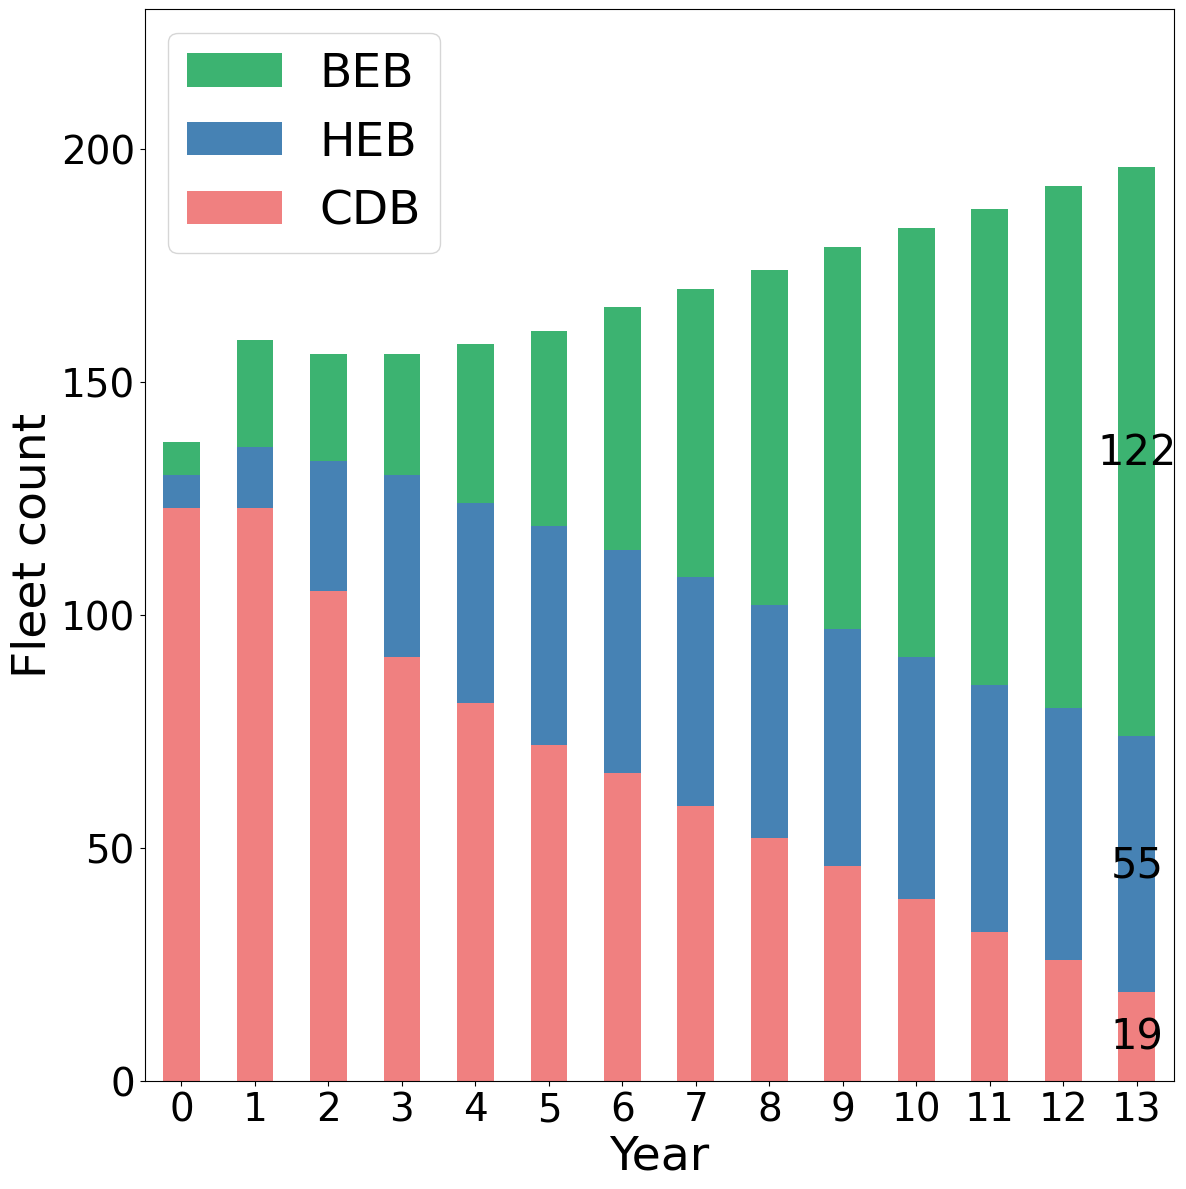

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Reorder the columns
grouped_values = grouped_values[['CDB', 'HEB', 'BEB']]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values for the last bar
for container_idx, container in enumerate(ax.containers):
    for rect_idx, rect in enumerate(container):
        if rect_idx == len(container) - 1:  # Annotate only the last bar
            height = rect.get_height()
            ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        ha='center', 
                        va='center',
                        color='black',  
                        fontsize=30)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=34)
ax.set_ylabel('Fleet count', fontsize=34)

# Reverse the order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34)

ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 230)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=28)

plt.tight_layout()

fig.savefig(r'../../figures/m_BM_fleet.png', dpi=400)  

plt.show()


In [30]:
total_sum = (m_BM_variables['Value'] * m_BM_variables['Coefficient']).sum()
print(total_sum)

24109.423714819997


In [31]:
### BM Low-cap Scenario

In [32]:
l_BM_variables = pd.read_csv(r'../../results/lowcap-BM-optimized-variables.csv', low_memory=False)

In [33]:
l_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [34]:
# Extract attributes from l_BM_variables
l_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
l_BM_variables = l_BM_variables.dropna()
l_BM_variables['Year'] = l_BM_variables['Year'].astype(int)
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_BM_variables['Trip'] = l_BM_variables['Trip'].astype(str)

# Extract attributes from h_BM_coefficients
l_BM_coefficients[['Scenario', 'Year', 'Trip']] = l_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
l_BM_coefficients = l_BM_coefficients.dropna()
l_BM_coefficients['Year'] = l_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_BM_variables['Trip'] = l_BM_variables['Trip'].astype(str)
l_BM_coefficients['Trip'] = l_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(l_BM_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update l_BM_variables
l_BM_variables = merged_df

In [35]:
# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update l_BM_variables
l_BM_variables = merged_df

l_BM_variables['ServiceDateTime_min'] = pd.to_datetime(l_BM_variables['ServiceDateTime_min'])
l_BM_variables['ServiceDateTime_max'] = pd.to_datetime(l_BM_variables['ServiceDateTime_max'])

In [36]:
l_BM_variables.to_csv(r'../../results/lowcap-BM-optimized-variables-aggregated.csv', index=False)

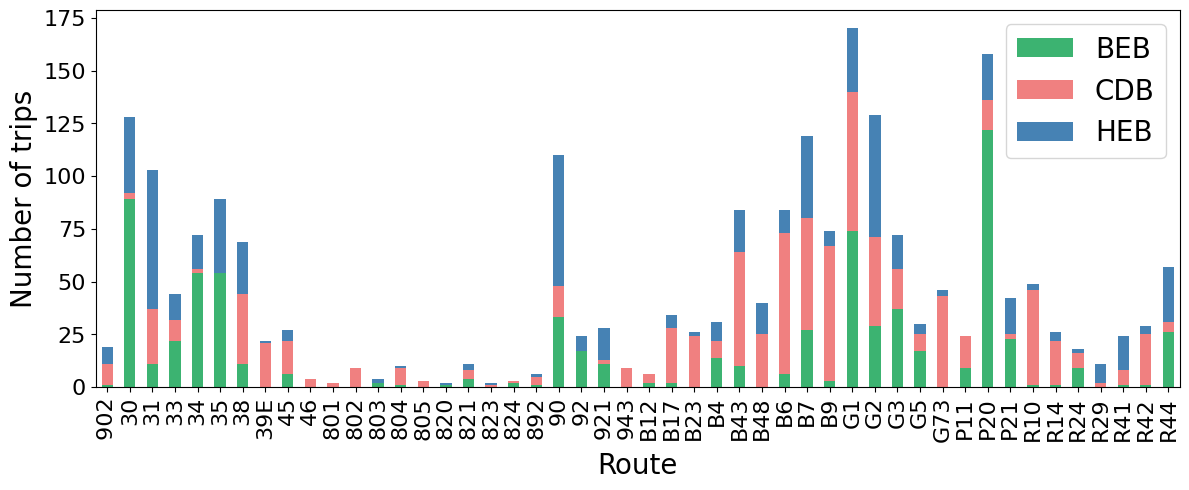

In [37]:
# Filter the dataframe for Year=13 and Value=1
l_BM_variables_filtered = l_BM_variables[(l_BM_variables['Year'] == 12) & (l_BM_variables['Value'] == 1)]
l_BM_variables_filtered = l_BM_variables_filtered[l_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/l_BM_route_electrification.png', dpi=400)  

plt.show()


In [38]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 33.62%


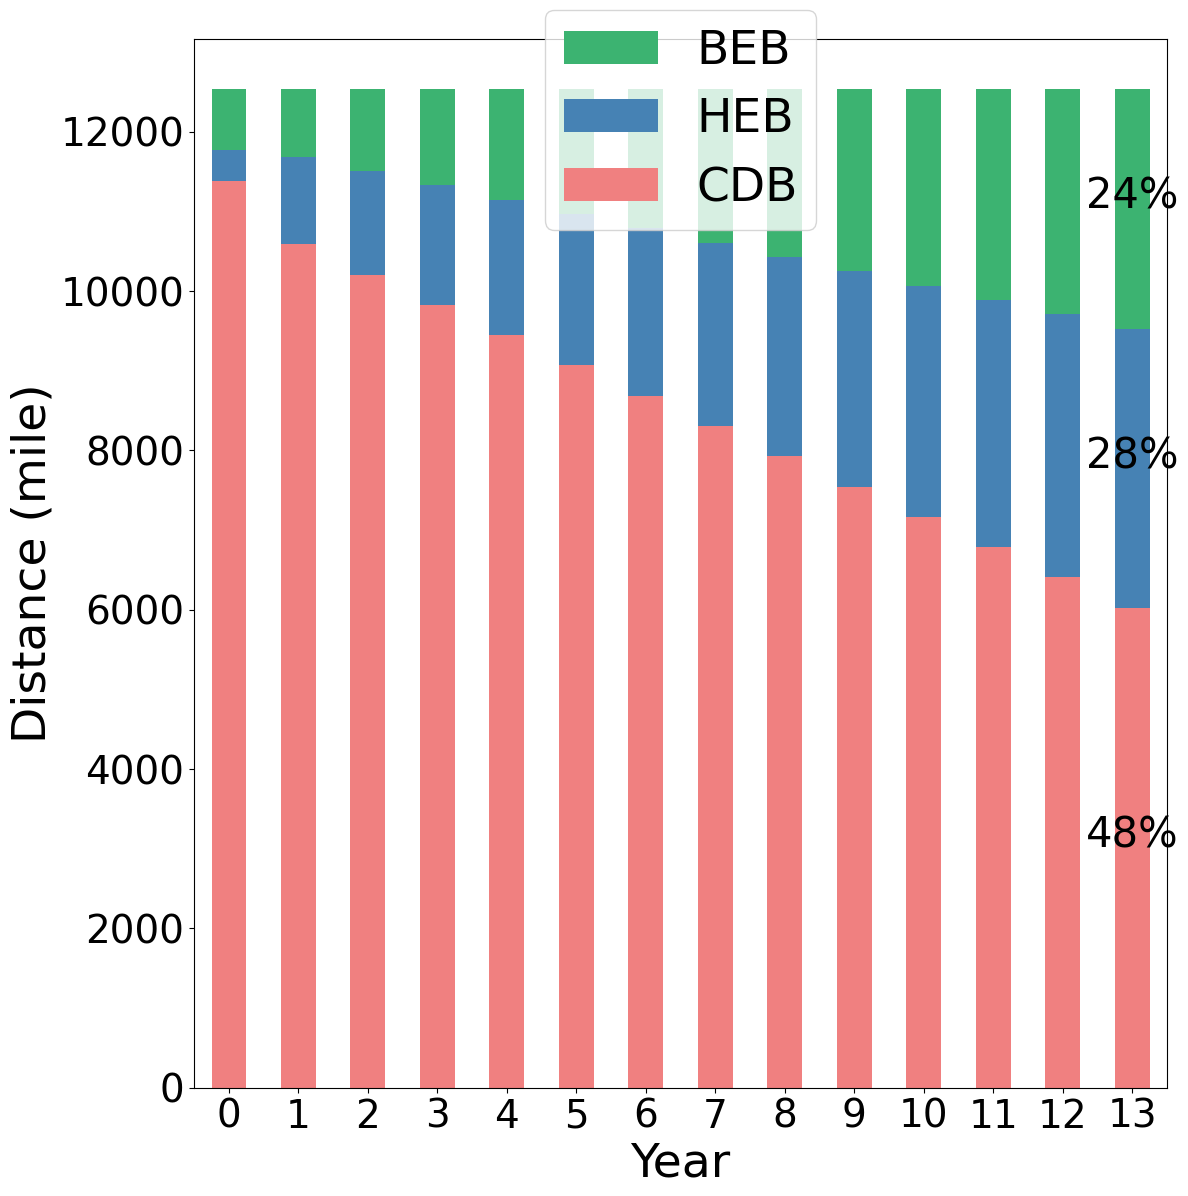

In [40]:
# Sum the 'dist' for each 'Powertrain' and 'Year'
l_BM_variables_values = l_BM_variables[l_BM_variables['Value'] == 1]
sum_dist = l_BM_variables_values.groupby(['Year', 'Powertrain'])['dist'].sum().reset_index()

# Pivot the DataFrame for easier plotting
pivot_dist = sum_dist.pivot(index='Year', columns='Powertrain', values='dist').fillna(0)

# Shift years by one
pivot_dist.reset_index(inplace=True)
pivot_dist['Year'] = pivot_dist['Year'] + 1

# Adding the new row for Year 0 (2022)
new_row = pd.DataFrame({'Year': [0], 'CDB': [11386], 'HEB': [382], 'BEB': [772]})
pivot_dist = pd.concat([pivot_dist, new_row], ignore_index=True)

# Sorting the DataFrame by Year
pivot_dist = pivot_dist.sort_values(by='Year').reset_index(drop=True)

# Setting the 'Year' as the index again if you want
pivot_dist.set_index('Year', inplace=True)

# Reorder the columns
pivot_dist = pivot_dist[['CDB', 'HEB', 'BEB']]

# Compute the percentage for annotation
pivot_percentage = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Define the colors
colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
pivot_dist.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_dist.columns], ax=ax)

# Annotate each bar with the corresponding percentage for the last year only
last_year_idx = len(pivot_dist.index) - 1
total_dist = 0
for j, powertrain in enumerate(pivot_dist.columns):
    percentage = pivot_percentage.loc[pivot_dist.index[last_year_idx], powertrain]
    dist = pivot_dist.loc[pivot_dist.index[last_year_idx], powertrain]
    if dist > 0:
        ax.text(last_year_idx, total_dist + dist / 2, f'{round(percentage)}%', ha='center', color='black', fontsize=30)
    total_dist += dist

# Setting labels, title, and making the fonts larger
plt.xlabel('Year', fontsize=34)
plt.ylabel('Distance (mile)', fontsize=34)
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(r'../../figures/l_BM_milage_electrification.png', dpi=400)

plt.show()


In [41]:
l_BM_variables_y = pd.read_csv(r'../../results/lowcap-BM-optimized-variables-y.csv', low_memory=False)

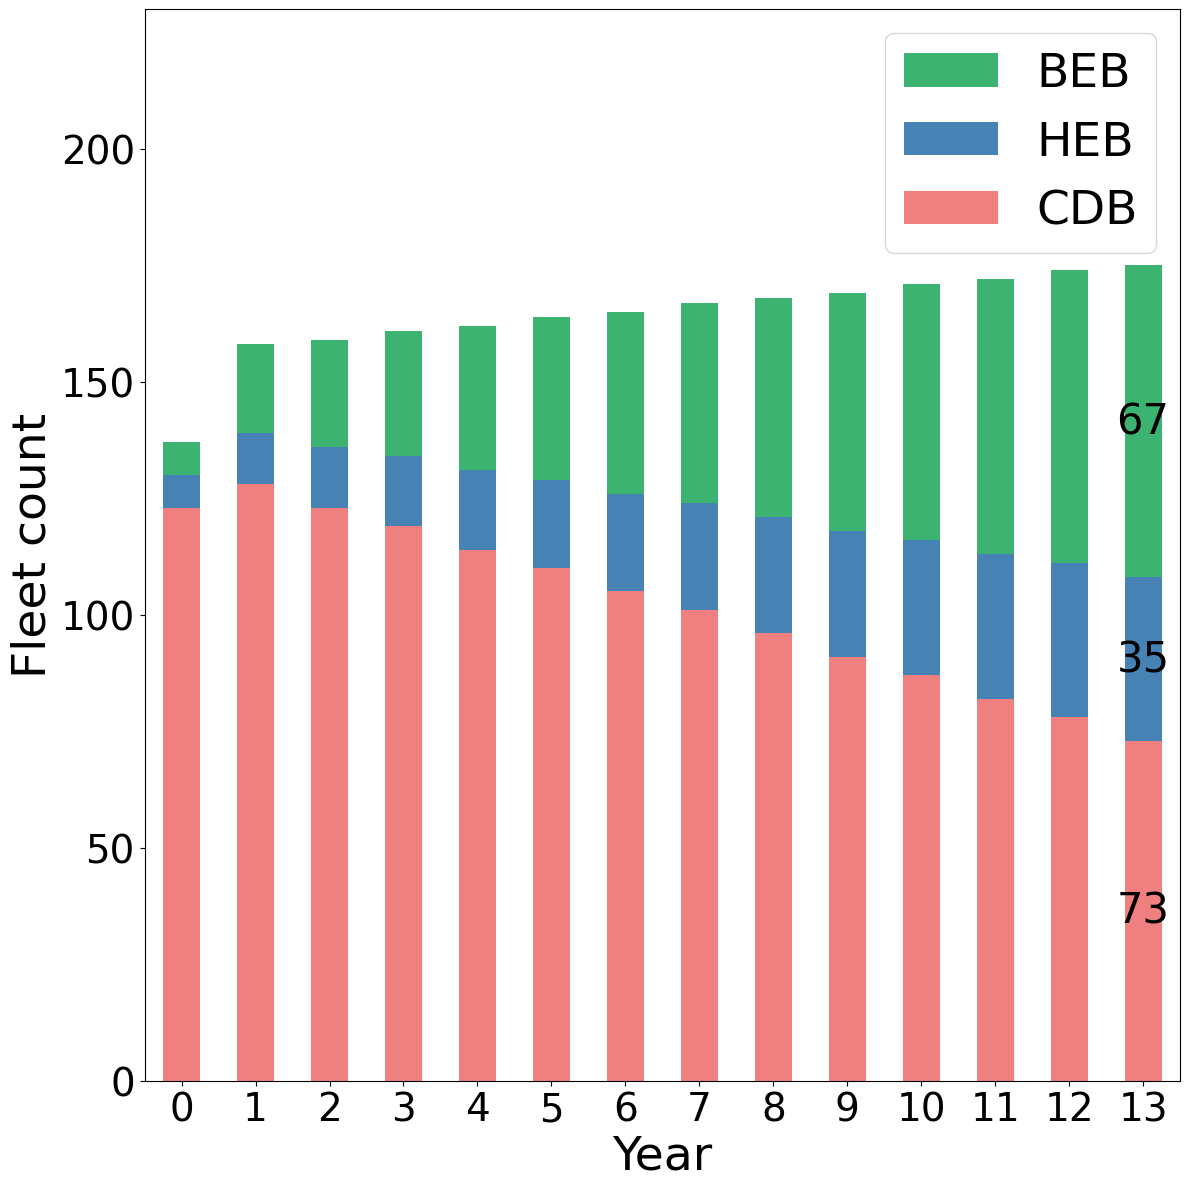

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Reorder the columns
grouped_values = grouped_values[['CDB', 'HEB', 'BEB']]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values for the last bar
for container_idx, container in enumerate(ax.containers):
    for rect_idx, rect in enumerate(container):
        if rect_idx == len(container) - 1:  # Annotate only the last bar
            height = rect.get_height()
            ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        ha='center', 
                        va='center',
                        color='black',  
                        fontsize=30)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=34)
ax.set_ylabel('Fleet count', fontsize=34)

# Reverse the order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34)

ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 230)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=28)

plt.tight_layout()

fig.savefig(r'../../figures/l_BM_fleet.png', dpi=400)  

plt.show()


In [43]:
total_sum = (l_BM_variables['Value'] * l_BM_variables['Coefficient']).sum()
print(total_sum)

29546.192010989005


In [44]:
# Calculate sum for each Year for each DataFrame
h_BM_variables['Result'] = h_BM_variables['Value'] * h_BM_variables['Coefficient']
h_BM_sum = h_BM_variables.groupby('Year')['Result'].sum().reset_index()

m_BM_variables['Result'] = m_BM_variables['Value'] * m_BM_variables['Coefficient']
m_BM_sum = m_BM_variables.groupby('Year')['Result'].sum().reset_index()

l_BM_variables['Result'] = l_BM_variables['Value'] * l_BM_variables['Coefficient']
l_BM_sum = l_BM_variables.groupby('Year')['Result'].sum().reset_index()

# Add Scenario and Strategy columns
h_BM_sum['Scenario'] = 'h'
h_BM_sum['Strategy'] = 'BM'

m_BM_sum['Scenario'] = 'm'
m_BM_sum['Strategy'] = 'BM'

l_BM_sum['Scenario'] = 'l'
l_BM_sum['Strategy'] = 'BM'

# Concatenate the DataFrames
final_df = pd.concat([h_BM_sum, m_BM_sum, l_BM_sum])

# Rearrange the columns
final_df = final_df[['Year', 'Result', 'Scenario', 'Strategy']]
final_df.to_csv(r'../../results/diesel-BM.csv', index=False)

In [45]:
final_df

,Year,Result,Scenario,Strategy
0,0,2585.116821,h,BM
1,1,2399.702312,h,BM
2,2,2230.392451,h,BM
3,3,2026.154242,h,BM
4,4,1887.270135,h,BM
5,5,1724.181732,h,BM
6,6,1545.212409,h,BM
7,7,1393.614636,h,BM
8,8,1247.632008,h,BM
9,9,1105.782710,h,BM


In [46]:
h_BM_variables

,Variable,Value,Powertrain,Scenario,Year,Trip,Coefficient,Route,Stop_first,Stop_last,ServiceDateTime_min,ServiceDateTime_max,dist,Result
0,"x_CDB[high-cap,0,504451]",1.0,CDB,high-cap,0,504451,0.247132,902,850,1920,2021-10-29 11:22:06,2021-10-29 11:28:50,3.527633,0.247132
1,"x_CDB[high-cap,0,504614]",1.0,CDB,high-cap,0,504614,1.558568,902,5105,850,2021-10-29 15:06:30,2021-10-29 15:31:15,6.489336,1.558568
2,"x_CDB[high-cap,0,504672]",1.0,CDB,high-cap,0,504672,1.611629,902,5105,850,2021-10-29 12:37:10,2021-10-29 13:00:22,6.489336,1.611629
3,"x_CDB[high-cap,0,504850]",-0.0,CDB,high-cap,0,504850,0.460382,902,5105,5105,2021-10-29 17:36:16,2021-10-29 17:36:16,0.079722,-0.000000
4,"x_CDB[high-cap,0,504944]",1.0,CDB,high-cap,0,504944,0.245797,902,850,1920,2021-10-29 13:50:58,2021-10-29 13:57:06,3.527633,0.245797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92269,"x_BEB[high-cap,12,505502]",1.0,BEB,high-cap,12,505502,0.000000,92,850,5114,2021-10-29 13:00:19,2021-10-29 14:00:19,4.907396,0.000000
92270,"x_BEB[high-cap,12,507042]",1.0,BEB,high-cap,12,507042,0.000000,92,5114,850,2021-10-29 12:01:34,2021-10-29 13:00:19,5.847957,0.000000
92271,"x_BEB[high-cap,12,507043]",1.0,BEB,high-cap,12,507043,0.000000,92,5114,850,2021-10-29 14:00:19,2021-10-29 15:00:01,5.690529,0.000000
92272,"x_BEB[high-cap,12,507044]",1.0,BEB,high-cap,12,507044,0.000000,92,850,5114,2021-10-29 16:48:52,2021-10-29 18:02:00,4.907396,0.000000
